<a href="https://colab.research.google.com/github/mylethidiem/artificial-intelligence-projects/blob/main/Architecture%20Project%20Gradient%20Vanishing%20in%20MLP/1.1_WeightIncreasing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **0. Import libraries**

In [ ]:
import random
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

from torch import nn
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision.datasets import FashionMNIST

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else "cpu")
print(device)

def set_seed(seed):
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
  torch.backends.cudnn.benchmark = False
  torch.backends.cudnn.deterministic = True

SEED = 42
set_seed(SEED)

cuda


## **1. Prepare dataset**


In [ ]:
train_dataset = FashionMNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
test_dataset = FashionMNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())

100%|██████████| 26.4M/26.4M [00:02<00:00, 10.4MB/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 170kB/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:01<00:00, 3.20MB/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 5.17MB/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



In [ ]:
train_ratio = 0.9
train_size = int(train_ratio * len(train_dataset))
val_size = len(train_dataset) - train_size

train_subset, val_subset = random_split(train_dataset, [train_size, val_size])

batch_size = 64
train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
print(f"Train size: {len(train_subset)}")
print(f"Validation size: {len(val_subset)}")
print(f"Test size: {len(test_dataset)}")

Train size: 54000
Validation size: 6000
Test size: 10000


## **2. Build MLP network with `Weight Increasing (std=1.0)`**




In [ ]:
class MLP(nn.Module):
  def __init__(self, input_dims, hidden_dims, output_dims):
    super(MLP, self).__init__()
    self.layer1 = nn.Linear(input_dims, hidden_dims)
    self.layer2 = nn.Linear(hidden_dims, hidden_dims)
    self.layer3 = nn.Linear(hidden_dims, hidden_dims)
    self.layer4 = nn.Linear(hidden_dims, hidden_dims)
    self.layer5 = nn.Linear(hidden_dims, hidden_dims)
    self.layer6 = nn.Linear(hidden_dims, hidden_dims)
    self.layer7 = nn.Linear(hidden_dims, hidden_dims)
    self.output = nn.Linear(hidden_dims,output_dims)

    # Lặp qua tất cả các module (layer) trong mô hình
    for module in self.modules():
      # Kiểm tra nếu module là một lớp Linear
      if isinstance(module, nn.Linear):
        # Khởi tạo trọng số (weight) theo phân phối chuẩn
        # với mean=0.0 và độ lệch chuẩn std=1.0
        nn.init.normal_(module.weight, mean=0.0, std=1.0)
        nn.init.constant_(module.bias, 0.0) # Khởi tạo bias với giá trị hằng số 0.0

  def forward(self, x):
    x = nn.Flatten()(x)
    x = self.layer1(x)
    x = nn.Sigmoid()(x)
    x = self.layer2(x)
    x = nn.Sigmoid()(x)
    x = self.layer3(x)
    x = nn.Sigmoid()(x)
    x = self.layer4(x)
    x = nn.Sigmoid()(x)
    x = self.layer5(x)
    x = nn.Sigmoid()(x)
    x = self.layer6(x)
    x = nn.Sigmoid()(x)
    x = self.layer7(x)
    x = nn.Sigmoid()(x)
    output = self.output(x)
    return output



In [ ]:
input_dims = 784
hidden_dims = 128
output_dims = 10
model = MLP(input_dims=input_dims,
            hidden_dims=hidden_dims,
            output_dims=output_dims).to(device)

criterion = nn.CrossEntropyLoss()
lr = 1e-2
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

## **3. Training**

In [ ]:
epochs = 100
train_loss_list = []
val_loss_list = []
train_acc_list = []
val_acc_list = []

for epoch in range(epochs):
  # 1) train steps
  train_loss = 0.0
  train_acc = 0.0
  sum_sample = 0

  model.train()
  for X_train, y_train in train_loader:
    X_train, y_train = X_train.to(device), y_train.to(device)
    optimizer.zero_grad()

    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()

    train_loss += loss.item()
    train_acc += (torch.argmax(outputs, dim=1) == y_train).sum().item()

    sum_sample += len(y_train)

  train_loss /= len(train_loader)
  train_acc /= sum_sample
  train_loss_list.append(train_loss)
  train_acc_list.append(train_acc)

  # 2) validation steps
  val_loss = 0.0
  val_acc = 0.0
  model.eval()
  sum_sample = 0
  with torch.no_grad():
    for X_val, y_val in val_loader:
      X_val, y_val = X_val.to(device), y_val.to(device)

      outputs = model(X_val)
      loss = criterion(outputs, y_val)

      val_loss += loss.item()
      val_acc += (torch.argmax(outputs, dim=1) == y_val).sum().item()

      sum_sample += len(y_val)

  val_loss /= len(val_loader)
  val_acc /= sum_sample
  val_loss_list.append(val_loss)
  val_acc_list.append(val_acc)

  print(f"EPOCH {epoch+1}/{epochs}, Train_Loss: {train_loss:.4f},Train_Acc: {train_acc:.4f}, Validation Loss: {val_loss:.4f} , Val_Acc:{val_acc:.4f}")



EPOCH 1/100, Train_Loss: 1.9746,Train_Acc: 0.3767, Validation Loss: 1.3957 , Val_Acc:0.5095
EPOCH 2/100, Train_Loss: 1.2380,Train_Acc: 0.5604, Validation Loss: 1.1413 , Val_Acc:0.5935
EPOCH 3/100, Train_Loss: 1.0554,Train_Acc: 0.6195, Validation Loss: 1.0213 , Val_Acc:0.6243
EPOCH 4/100, Train_Loss: 0.9580,Train_Acc: 0.6557, Validation Loss: 0.9486 , Val_Acc:0.6562
EPOCH 5/100, Train_Loss: 0.8963,Train_Acc: 0.6777, Validation Loss: 0.8971 , Val_Acc:0.6835
EPOCH 6/100, Train_Loss: 0.8527,Train_Acc: 0.6932, Validation Loss: 0.8628 , Val_Acc:0.6955
EPOCH 7/100, Train_Loss: 0.8184,Train_Acc: 0.7064, Validation Loss: 0.8301 , Val_Acc:0.7103
EPOCH 8/100, Train_Loss: 0.7912,Train_Acc: 0.7154, Validation Loss: 0.8085 , Val_Acc:0.7167
EPOCH 9/100, Train_Loss: 0.7681,Train_Acc: 0.7243, Validation Loss: 0.7869 , Val_Acc:0.7275
EPOCH 10/100, Train_Loss: 0.7491,Train_Acc: 0.7312, Validation Loss: 0.7682 , Val_Acc:0.7325
EPOCH 11/100, Train_Loss: 0.7322,Train_Acc: 0.7384, Validation Loss: 0.7520 , V

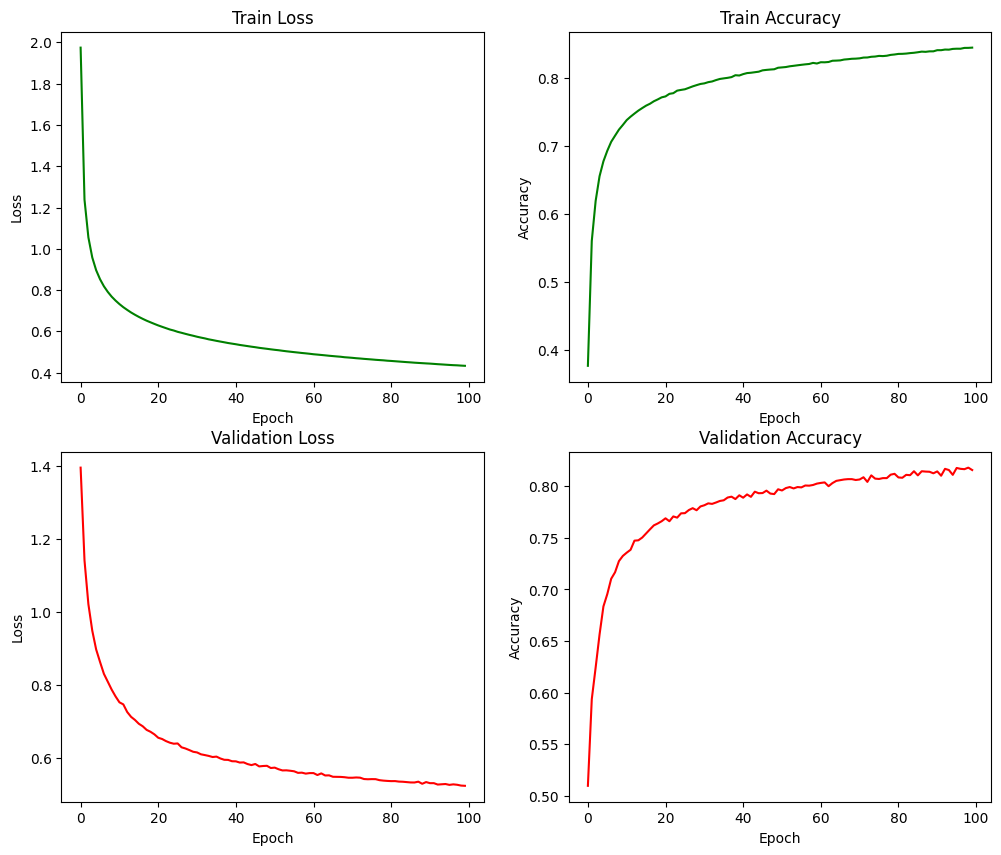

In [ ]:
fig, ax = plt.subplots(2,2, figsize=(12,10))
ax[0,0].plot(train_loss_list, color='green')
ax[0,0].set(title='Train Loss', xlabel='Epoch', ylabel='Loss')

ax[0,1].plot(train_acc_list, color='green')
ax[0,1].set(title='Train Accuracy', xlabel='Epoch', ylabel='Accuracy')

ax[1,0].plot(val_loss_list, color='red')
ax[1,0].set(title='Validation Loss', xlabel='Epoch', ylabel='Loss')

ax[1,1].plot(val_acc_list, color='red')
ax[1,1].set(title='Validation Accuracy', xlabel='Epoch', ylabel='Accuracy')
plt.show()

## **4. Evaluation**

In [ ]:
test_ground_truth = []
test_prediction = []

model.eval()
with torch.no_grad():
  for X_test, y_test in test_loader:
    X_test, y_test = X_test.to(device), y_test.to(device)

    outputs = model(X_test)

    test_ground_truth.append(y_test.cpu())
    test_prediction.append(outputs.cpu())

test_ground_truth = torch.cat(test_ground_truth, dim=0)
test_prediction = torch.cat(test_prediction, dim=0)

test_acc = (torch.argmax(test_prediction,1) == test_ground_truth).sum().item() / len(test_ground_truth)
print(f"Test Accuracy: {test_acc:.4f}")

Test Accuracy: 0.8067


Thử nghiệm lại trên tập validation

In [ ]:
val_target = []
val_predict = []

model.eval()
with torch.no_grad():
    for X_val, y_val in val_loader:
        X_val = X_val.to(device)
        y_val = y_val.to(device)
        outputs = model(X_val)

        val_predict.append(outputs.cpu())
        val_target.append(y_val.cpu())

    val_predict = torch.cat(val_predict)
    val_target = torch.cat(val_target)
    val_acc = (torch.argmax(val_predict, 1) == val_target).sum().item() / len(val_target)

    print('Evaluation on val set:')
    print(f'Accuracy: {val_acc}')

Evaluation on val set:
Accuracy: 0.8158333333333333
